Name : Nur Aufa, Student ID : 1101220508

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [15]:
xz_transaction = pd.read_csv(r"C:\Users\dell0\Downloads\Case_Study_Transaction.csv", sep = ';')
xz_customer = pd.read_csv(r"C:\Users\dell0\Downloads\Case_Study_Customer.csv", sep = ';')
xz_store = pd.read_csv(r"C:\Users\dell0\Downloads\Case_Study_Store.csv", sep = ';')
xz_product = pd.read_csv(r"C:\Users\dell0\Downloads\Case_Study_Product.csv", sep = ';')

In [19]:
xz_customer['Income'] = xz_customer['Income'].replace('[,]','.',regex=True)

In [21]:
xz_store['Latitude'] = xz_store['Latitude'].replace('[,]','.',regex=True)

In [23]:
xz_store['Longitude'] = xz_store['Longitude'].replace('[,]','.',regex=True)

In [25]:
xz_transaction['Date'] = pd.to_datetime(xz_transaction['Date'],format='mixed')

In [27]:
xz_merge = pd.merge(xz_transaction, xz_customer, on=['CustomerID'])
xz_merge = pd.merge(xz_merge, xz_product.drop(columns=['Price']), on=['ProductID'])
xz_merge = pd.merge(xz_merge, xz_store, on=['StoreID'])

In [31]:
xz_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR16356,165,2022-01-01,P9,10000,7,70000,1,44,1,Married,14.58,Yoghurt,Prima Tendean,Prima,Modern Trade,-6.2,106.816666
2,TR1984,183,2022-01-01,P1,8800,4,35200,4,27,1,Single,0.18,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664
3,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,1,Married,12.57,Choco Bar,Gita Ginara,Gita,General Trade,-6.966667,110.416664
4,TR41231,386,2022-01-01,P9,10000,1,10000,4,33,0,Married,6.95,Yoghurt,Gita Ginara,Gita,General Trade,-6.966667,110.416664


In [37]:
xz_regresi = xz_merge.groupby(['Date']).agg({    
    'Qty' : 'sum'
}).reset_index()

In [39]:
xz_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


In [41]:
#Split Data 
split_index = int(len(xz_regresi) * 0.8) 
xz_train = xz_regresi.iloc[:split_index].copy() 
xz_test = xz_regresi.iloc[split_index:].copy()

In [49]:
def eval(y_true, y_pred):    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)    
    print(f"MAE: {mae}, MSE: {mse}")

In [69]:
print(xz_train.columns)
print(xz_train.head())

Index(['Qty'], dtype='object')
            Qty
Date           
2022-01-01   49
2022-01-02   50
2022-01-03   76
2022-01-04   98
2022-01-05   67


D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inverti

MAE: 12.357279628127598, MSE: 239.39852055758138


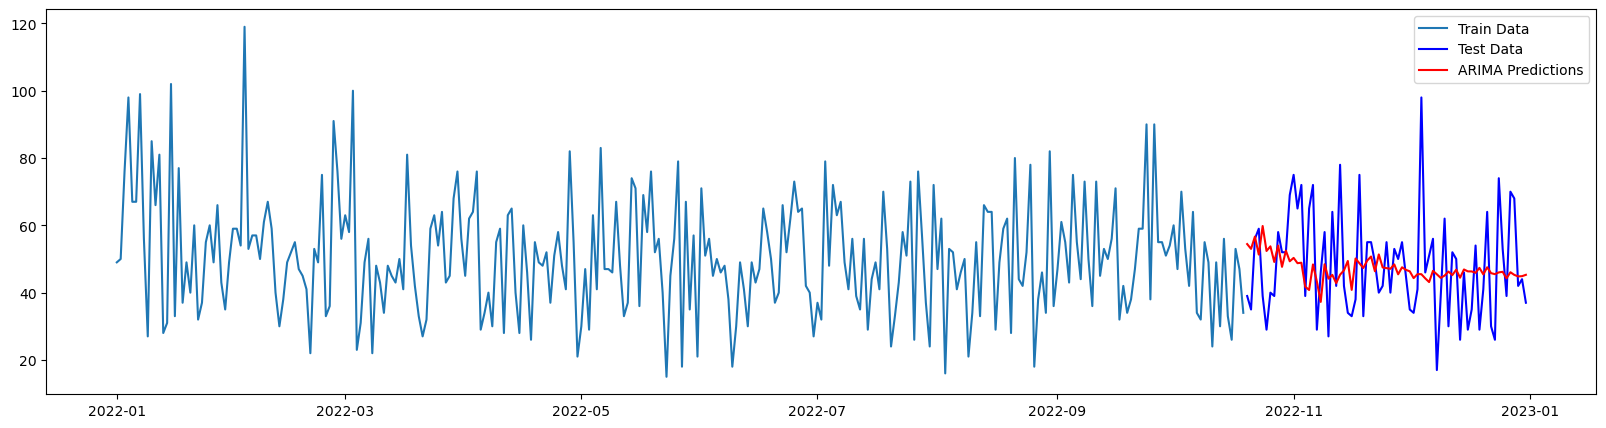

In [75]:
# Tidak perlu set index lagi jika 'Date' sudah menjadi index
# Cukup menggunakan xz_train dan xz_test yang sudah memiliki index 'Date'
y = xz_train['Qty']  # Ambil kolom 'Qty' untuk training

# Fit model ARIMA
ARIMAmodel = ARIMA(y, order=(40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

# Forecast dan hasilkan prediksi
y_pred = ARIMAmodel.get_forecast(len(xz_test))
y_pred_xz = y_pred.conf_int()

# Menggunakan index yang sudah ada
y_pred_xz['predictions'] = ARIMAmodel.predict(start=y_pred_xz.index[0], end=y_pred_xz.index[-1])

# Pastikan index predictions sama dengan index xz_test
y_pred_xz.index = xz_test.index

# Ambil hasil prediksi
y_pred_out = y_pred_xz['predictions']

# Evaluasi model (gunakan metrik yang sesuai)
eval(xz_test['Qty'], y_pred_out)

# Plot hasilnya
plt.figure(figsize=(20, 5))
plt.plot(xz_train['Qty'], label='Train Data')
plt.plot(xz_test['Qty'], color='blue', label='Test Data')
plt.plot(y_pred_out, color='red', label='ARIMA Predictions')
plt.legend()
plt.show()
